### Demo25 : GAN (Generative Adversaiaj network) 生成對抗網路
use colab 比較快

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
# mnist data set load
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               25600     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                                      

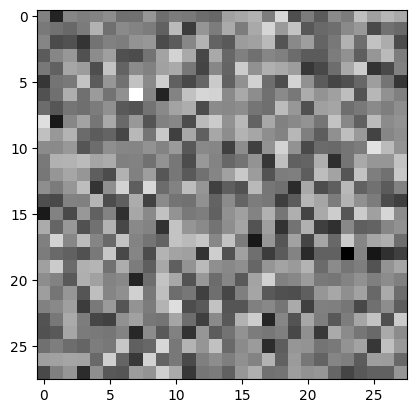

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()   
    model.add(layers.Dense(256, use_bias=False, input_shape=(100,))) # input is noise=100 D 
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(28*28), activation='tanh'))
    model.add(layers.Reshape((28,28,1)))
    model.summary()
    return model
generator = make_generator_model()
noise = tf.random.normal([1, 100]) # mean is 0, stddev ia 1.0
print('noise=\n',noise)
generated_image = generator(noise, training=False) # 產生假照片
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))  # input is 假照片
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))  # output is 0~1 的數字評分
    model.summary()
    return model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

In [ ]:
# output is 1 : use BinaryCrossentropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    # 對應 page 25-17 公式
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  #真照片loss
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #假照片loss
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if epoch % 50 == 0:
            generate_and_save_images(generator,epoch + 1,seed)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    generate_and_save_images(generator,epochs,seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')

In [ ]:
train(train_dataset, EPOCHS)

### online GAN : 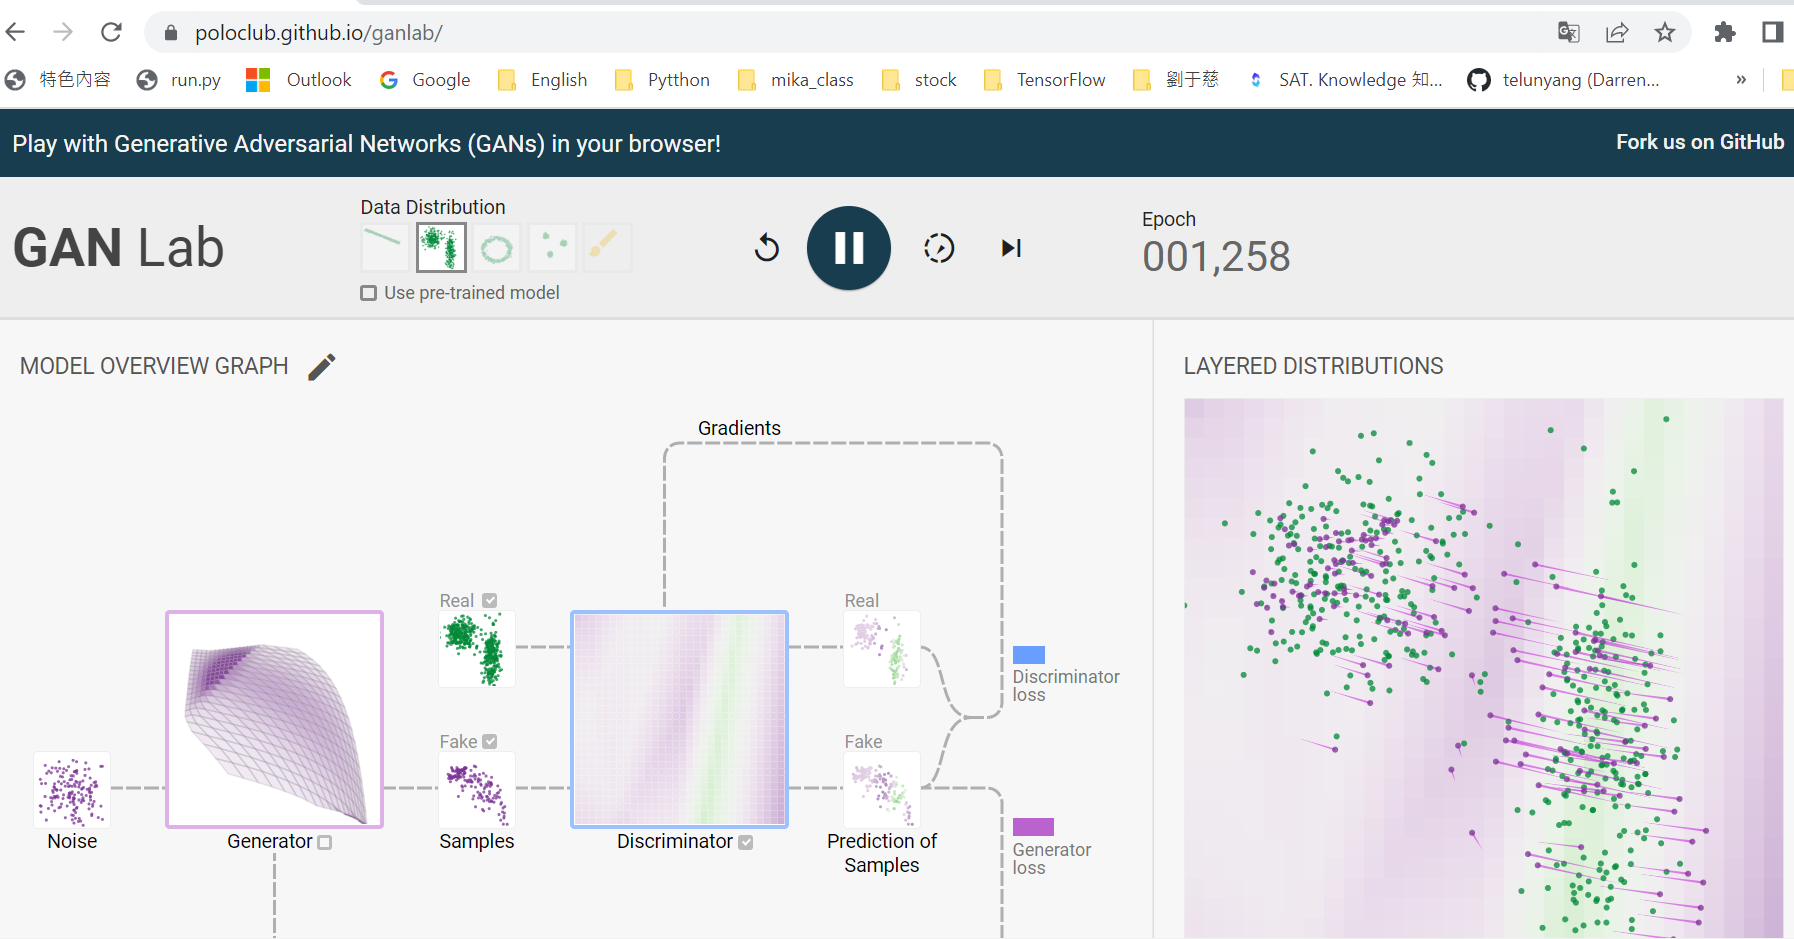